In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime

Сделаем бейзлайн на основе catboost'а. Будем считать максимально просто, будем смотреть на реакцию изменения цены акции на новость.

In [47]:
df = pd.read_csv('../data/data_proc.csv')
df['delta close'] =  df['close + 1 hour'] - df['close']

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Предполагаем, что df - ваш DataFrame с данными (замените на pd.read_csv('your_file.csv'))
# Колонки: 'views', 'close', 'close + 30 minutes', 'close + 1 hour', 'close + -30 minutes', 'close + -1 hour', 'sent_scores', 'sent_labels', 'delta close'
# Drop NaN для чистоты

# Подготовка фич (убрали 'close + 30 minutes', 'close + 1 hour', 'sent_labels')
features = [feature for feature in df.columns if 'close' or 'sent_scores' or 'views' in feature]
features.remove('close + 30 minutes')
features.remove('close + 1 hour')
X = df[features]
y = df['close + 1 hour']  # Target теперь 'close + 1 hour' (цена через час)

# Split на train/test (80/20, с учётом времени - сортируем по date)
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Модель бустинга: XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Для регрессии
    n_estimators=100,              # Число деревьев
    learning_rate=0.1,             # Шаг обучения
    max_depth=3,                   # Глубина деревьев
    random_state=42
)

# Обучение
model.fit(X_train, y_train)

# Предсказание на test
y_pred = model.predict(X_test)

# Оценка (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Для нового предсказания: model.predict(new_data) - new_data в формате DataFrame с features

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: object

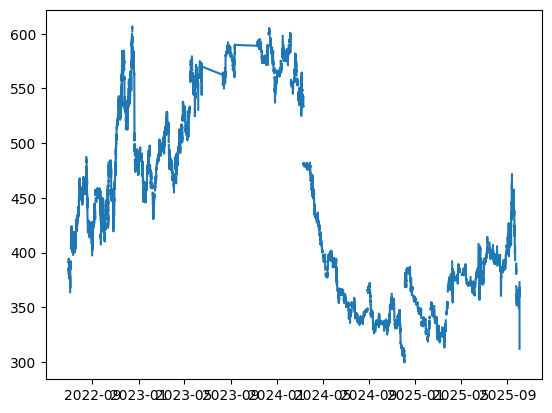

In [ ]:
plt.plot(pd.to_datetime(df['date']), df['close'])
df = df.dropna()

<Axes: >

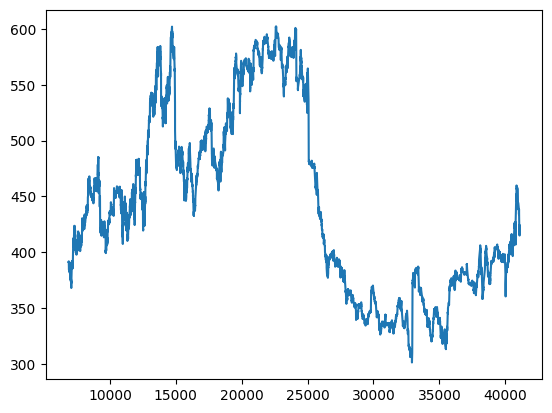

In [ ]:
df.dropna()['close'].plot()

ValueError: x and y must have same first dimension, but have shapes (8299,) and (2714,)

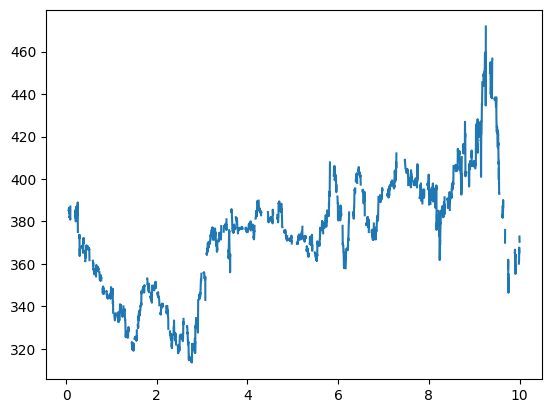

In [ ]:

plt.plot(np.linspace(0, 10, len(y_test)), y_test)
plt.plot(np.linspace(0, 10, len(y_test)), y_pred)

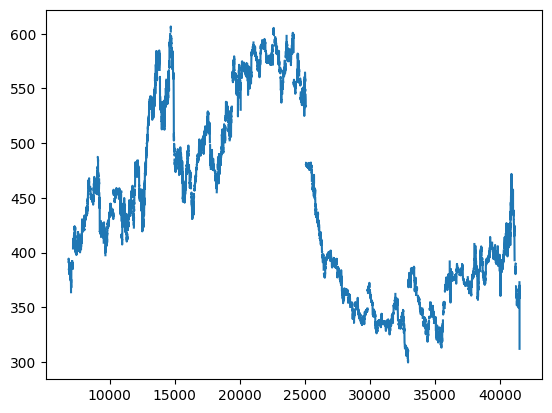

In [ ]:
plt.plot(df['close'])

SyntaxError: invalid syntax (1712399413.py, line 1)

Решим задачу с помощью GRU

,Unnamed: 0,date,views,close,close + 30 minutes,close + 1 hour,close + -30 minutes,close + -1 hour,sent_scores,sent_labels,delta close
1,6862,2022-06-30 12:27:00,25432,394.45,394.30,394.35,394.80,395.00,-0.000452,1.0,-0.10
2,6863,2022-06-30 12:31:00,663,390.90,390.80,389.65,391.20,390.80,0.000141,1.0,-1.25
3,6864,2022-06-30 12:49:00,5098,391.00,390.95,389.90,390.95,391.10,0.214055,1.0,-1.10
4,6865,2022-06-30 13:30:00,300,391.00,390.95,389.90,390.95,391.10,0.149373,1.0,-1.10
5,6866,2022-06-30 14:00:00,701,391.25,390.80,390.95,390.80,390.90,0.098597,1.0,-0.30
...,...,...,...,...,...,...,...,...,...,...,...
22996,41410,2025-10-01 02:17:00,4575,361.90,363.25,366.70,359.05,356.90,-0.585977,0.0,4.80
22997,41411,2025-10-01 03:02:00,950,358.40,361.40,363.95,349.70,355.25,-0.520476,0.0,5.55
22998,41412,2025-10-01 04:41:00,12500,349.70,358.40,361.40,355.25,369.20,-0.000210,1.0,11.70
23013,41482,2025-10-02 21:23:00,733,365.15,361.10,361.05,365.40,372.90,0.580146,2.0,-4.10


In [55]:
df = df.dropna()

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

features = [feature for feature in df.columns if 'close' or 'sent_scores' or 'views' in feature]
features.remove('close + 1 hour')
features.remove('close + 30 minutes')
features.remove('delta close')
features.remove('date')
features.remove('Unnamed: 0')
features.remove('sent_labels')
seq_columns = [feature for feature in features if 'close' in feature]
print(features)

class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.scaler_price = MinMaxScaler()
        self.scaler_views = MinMaxScaler() 
        
        # Собираем все prices для fit scalers
        all_prices = np.concatenate([self.df[col].values for col in seq_columns]).reshape(-1, 1)
        self.scaler_price.fit(all_prices)
        
        # Нормализуем views и sent_scores
        self.df['views_norm'] = self.scaler_views.fit_transform(self.df['views'].values.reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sent = row['sent_scores']
        views = row['views_norm']
        
        prices = [row[feature] for feature in seq_columns]
        prices_norm = self.scaler_price.transform(np.array(prices).reshape(-1, 1)).flatten()
        
        seq = np.array([[p, sent, views] for p in prices_norm])
        seq = torch.tensor(seq, dtype=torch.float32) 
        
        target = torch.tensor(row['close + 1 hour'], dtype=torch.float32) 
        return seq, target

dataset = TimeSeriesDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


['views', 'close', 'close + -10 minutes', 'close + -20 minutes', 'close + -30 minutes', 'close + -40 minutes', 'close + -50 minutes', 'close + -60 minutes', 'close + -70 minutes', 'close + -80 minutes', 'close + -90 minutes', 'close + -100 minutes', 'close + -110 minutes', 'close + -120 minutes', 'close + -130 minutes', 'close + -140 minutes', 'close + -150 minutes', 'close + -160 minutes', 'close + -170 minutes', 'close + -180 minutes', 'close + -190 minutes', 'sent_scores']


In [62]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=3, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch, seq_len, input_size]
        out, hn = self.gru(x)
        final_out = self.fc(out[:, -1, :])  # Last timestep
        return final_out

In [ ]:
train_size = int(0.8 * len(df))  # 80% train, 20% val
df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:]

train_dataset = TimeSeriesDataset(df_train)
val_dataset = TimeSeriesDataset(df_val) 

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)  # No shuffle для val

model = GRUModel(input_size=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
patience = 1
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Train phase
    model.train()
    train_loss = 0
    for batch_seq, batch_target in train_dataloader:
        batch_seq, batch_target = batch_seq.to(device), batch_target.to(device)
        optimizer.zero_grad()
        output = model(batch_seq)
        loss = criterion(output.squeeze(), batch_target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_seq, batch_target in val_dataloader:
            batch_seq, batch_target = batch_seq.to(device), batch_target.to(device)
            output = model(batch_seq)
            loss = criterion(output.squeeze(), batch_target)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Сохраняем лучшую модель: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

,Unnamed: 0,date,views,close,close + 30 minutes,close + 1 hour,close + -30 minutes,close + -1 hour,sent_scores,sent_labels,delta close
1,6862,2022-06-30 12:27:00,25432,394.45,394.30,394.35,394.80,395.00,-0.000452,1.0,-0.10
2,6863,2022-06-30 12:31:00,663,390.90,390.80,389.65,391.20,390.80,0.000141,1.0,-1.25
3,6864,2022-06-30 12:49:00,5098,391.00,390.95,389.90,390.95,391.10,0.214055,1.0,-1.10
4,6865,2022-06-30 13:30:00,300,391.00,390.95,389.90,390.95,391.10,0.149373,1.0,-1.10
5,6866,2022-06-30 14:00:00,701,391.25,390.80,390.95,390.80,390.90,0.098597,1.0,-0.30
...,...,...,...,...,...,...,...,...,...,...,...
22996,41410,2025-10-01 02:17:00,4575,361.90,363.25,366.70,359.05,356.90,-0.585977,0.0,4.80
22997,41411,2025-10-01 03:02:00,950,358.40,361.40,363.95,349.70,355.25,-0.520476,0.0,5.55
22998,41412,2025-10-01 04:41:00,12500,349.70,358.40,361.40,355.25,369.20,-0.000210,1.0,11.70
23013,41482,2025-10-02 21:23:00,733,365.15,361.10,361.05,365.40,372.90,0.580146,2.0,-4.10
